In [1]:
import pandas as pd
import os
import load
from sklearn.model_selection import train_test_split 

In [2]:
data = load.shuffle_data()
train, test = train_test_split(data, test_size = 0.25, random_state=42)

In [3]:
import util
from collections import Counter
from numpy import random

In [4]:
def bag_of_words(sentence):
    cnt = Counter()
    for word in sentence:
        cnt[word]+=1
    return cnt

In [5]:
import time
import numpy as np

In [6]:
#6.4
def obj_function_for_one(Xi, yi, lamda, w):
    return util.dotProduct(w, w)*lamda/2 + max(0, 1-yi*util.dotProduct(w,Xi))
def obj_function(X,y,lamda,w):
    m = len(y)
    obj = 0
    for idx in range(m):
        obj+=obj_function_for_one(X[idx],y[idx], lamda,w)
    return obj/m

def pegasos(X, y, X_t, y_t, lamda, w = {}, t=0, iteration = 1000):
    start = time.time()
    m = len(y)
    lst = list(range(m))
    itr = 0
    while itr<iteration:
        obj = 0
        np.random.shuffle(lst)
        for idx in lst:
            t +=1
            eta = 1./(t*lamda)
            ywx = y[idx]*util.dotProduct(w, X[idx])
            #d1 = (1-eta*lamda)*w
            util.increment(w, -eta*lamda, w)
            if ywx<1:
                util.increment(w, eta*y[idx], X[idx])
        itr+=1
    end = time.time()
    print("Total time:", end-start)
    print("Loss is: ", obj_function(X_t, y_t, lamda, w))
    return w

In [128]:
data_unique = list(np.unique(data))

In [141]:
X_train = {}
y_train = []
for i in range(len(train)):
    X_train[i] = bag_of_words(train[i][:-1]) 
    y_train.append(train[i][-1])

X_test = {}
y_test = []
for i in range(len(test)):
    X_test[i] = bag_of_words(test[i][:-1]) 
    y_test.append(test[i][-1])

TypeError: unhashable type: 'list'

In [28]:
w_non = pegasos(X_train, y_train, X_test, y_test, 1, {}, 0, iteration = 5)

Total time: 71.24002504348755
Loss is:  0.8189490488890906


In [27]:
#6.5
def pegasos_sw(X, y, X_t, y_t, lamda, w = {}, t=0, iteration = 1000, threshold = 1e-2):
    start = time.time()
    m = len(y)
    lst = list(range(m))
    change = 1
    itr = 0
    s = 1
    W = {}
    prev_loss = obj_function(X_t, y_t, lamda, w)
    while change > threshold and itr<iteration:
        np.random.shuffle(lst)
        for idx in lst:
            t +=1
            eta = 1./(t*lamda)
            ywx = y[idx]*util.dotProduct(W, X[idx])
            s = (1-eta*lamda)*s
            if s==0:
                s=1
                W = {}
            elif ywx<1./s:
                util.increment(W, eta*y[idx]/s, X[idx]) 
        w = {}
        util.increment(w, s, W)
        latter_loss = obj_function(X_t, y_t, lamda, w)
        change = latter_loss-prev_loss
        prev_loss = latter_loss
        itr+=1
    end = time.time()
    print("Total time: {}".format(end-start))
    print("Loss is: ", obj_function(X_t, y_t, lamda, w))
    return w

In [60]:
w_sw = pegasos_sw(X_train, y_train, X_test, y_test, lamda = 1, iteration = 5)

Total time: 24.786855936050415
Loss is:  0.8821493888888471


In [11]:
#6.7
def predict(X_i, w):
    if util.dotProduct(X_i, w) > 0:
        return 1
    else:
        return -1
    
def percent_err(X, y, w):
    m = len(y)
    count_err = 0
    for idx in range(m):
        if predict(X[idx], w)!=y[idx]:
            count_err+=1
    return count_err/m

In [12]:
percent_err(X_test, y_test, w_sw)

0.286

In [44]:
np.std(predict_all(X_test, w_sw))

0.67260686883200949

In [42]:
def predict_all(X, w):
    m = len(X)
    predict_list = [predict(X[idx], w) for idx in range(m)]
    return predict_list 

In [206]:
w_lamda

{'marie': 0.0084953494126096506,
 'charlotte': -0.0014158915687682739,
 'rampling': 0.0014158915687682741,
 'aberdeen': -0.0037757108500487326,
 'and': 0.093920807394962239,
 'jean': 0.0018878554250243704,
 'bruno': 0.001415891568768275,
 'cremet': 0.00094392771251218359,
 'sorcerer': -0.0023598192812804559,
 'are': -0.0051916024188170193,
 'a': -0.023598192812804633,
 'comfortable': 0.0018878554250243646,
 'sixtyish': 0.00047196385625609179,
 'married': -0.0033037469937926378,
 'couple': -0.011327132550146174,
 'looking': -0.0070794578438413596,
 'forward': -0.0066074939875852817,
 'to': -0.032093542225414259,
 'peaceful': 0.0023598192812804564,
 'vacation': 0.0023598192812804577,
 'at': -0.024542120525316766,
 'their': 0.013686951831426644,
 'second': -0.0047196385625609093,
 'home': 0.0023598192812804542,
 'in': 0.021238373531524097,
 'lit': -0.001415891568768273,
 'et': 0.0018878554250243663,
 'mix': 0.00094392771251218522,
 'on': -0.045308530200584819,
 'first': 1.3100631690576867

In [54]:
#6.8
lambda_list = np.arange(-3,1, 0.25, dtype=float)
err_list = []
std_list = []
for i in 10**lambda_list:
    w_lamda = pegasos_sw(X_train, y_train, X_test, y_test,lamda = i,iteration = 400, threshold = 1e-10)
    err_list.append(percent_err(X_test, y_test, w_lamda))
    std_list.append(np.std(predict_all(X_test, w_lamda)))

Total time: 10.945681095123291
Loss is:  147.928444445
Total time: 10.390838146209717
Loss is:  137.508610145
Total time: 17.913114070892334
Loss is:  137.329945995
Total time: 11.47960114479065
Loss is:  55.4667765984
Total time: 11.472051858901978
Loss is:  23.1291444445
Total time: 18.42026400566101
Loss is:  9.39782962797
Total time: 18.18358874320984
Loss is:  4.10555980143
Total time: 12.543864727020264
Loss is:  3.83268923137
Total time: 11.55044412612915
Loss is:  2.21604833333
Total time: 12.29870891571045
Loss is:  1.3056397662
Total time: 18.964948892593384
Loss is:  0.974455578547
Total time: 16.121215105056763
Loss is:  0.937615296739
Total time: 15.462011814117432
Loss is:  0.721441944444
Total time: 21.650003910064697
Loss is:  0.766240010335
Total time: 6.286622047424316
Loss is:  0.895497976804
Total time: 6.784614086151123
Loss is:  0.889943431353


In [50]:
std_list/np.sqrt(500)

array([ 0.03852106,  0.04451481,  0.01620963,  0.04033301,  0.03084879,
        0.04318333,  0.04165343,  0.03872983,  0.02533867,  0.03359762,
        0.03980111,  0.01475561,  0.04466981,  0.038626  ,  0.03359762,
        0.04313477])

In [ ]:
err_list

In [15]:
import matplotlib.pyplot as plt

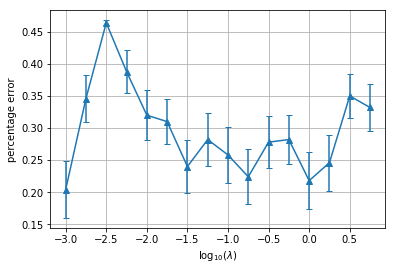

In [55]:
plt.errorbar(lambda_list, err_list, std_list/np.sqrt(500), marker='^', capsize=3)
plt.xlabel('$\log_{10}(\lambda)$')
plt.ylabel('percentage error')
plt.grid()
plt.show()

Total time: 11.03639006614685
Loss is:  7.05918780588
Total time: 11.228457927703857
Loss is:  5.52177484267
Total time: 11.107009887695312
Loss is:  2.91508419175
Total time: 11.229002952575684
Loss is:  2.72785777778
Total time: 12.634659767150879
Loss is:  1.91413923967
Total time: 11.693467855453491
Loss is:  2.24057117048
Total time: 11.776242733001709
Loss is:  0.82549996778
Total time: 14.572237014770508
Loss is:  0.787715475626
Total time: 5.954124927520752
Loss is:  0.951011777778
Total time: 6.608051061630249
Loss is:  0.931859280225


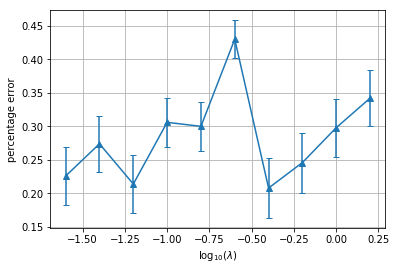

In [56]:
lambda_list2 = np.arange(-1.6, 0.4, 0.2, dtype=float)
err_list2 = []
std_list2 = []
for i in 10**lambda_list2:
    w_lamda = pegasos_sw(X_train, y_train, X_test, y_test,lamda = i,iteration = 400, threshold = 1e-10)
    err_list2.append(percent_err(X_test, y_test, w_lamda))
    std_list2.append(np.std(predict_all(X_test, w_lamda)))
    
plt.errorbar(lambda_list2, err_list2, std_list2/np.sqrt(500), marker='^', capsize=3)
plt.xlabel('$\log_{10}(\lambda)$')
plt.ylabel('percentage error')
plt.grid()
plt.show()

Total time: 16.186511039733887
Loss is:  1.9964943008
Total time: 11.727413892745972
Loss is:  2.18302495149
Total time: 12.090677976608276
Loss is:  1.45309176948
Total time: 12.184170961380005
Loss is:  1.05950785891
Total time: 12.246860980987549
Loss is:  2.19007615143
Total time: 11.795856952667236
Loss is:  1.2516769102
Total time: 11.771734952926636
Loss is:  1.60875951608
Total time: 18.945559978485107
Loss is:  0.750279885268
Total time: 12.834435939788818
Loss is:  0.948235821986
Total time: 12.673853874206543
Loss is:  1.71813748354
Total time: 12.839598178863525
Loss is:  1.9204350707
Total time: 11.96509599685669
Loss is:  1.05050173233
Total time: 13.832499265670776
Loss is:  0.813586146546
Total time: 5.556098937988281
Loss is:  0.918837985635
Total time: 5.442255020141602
Loss is:  0.999988302351
Total time: 5.551178932189941
Loss is:  0.950853349511
Total time: 13.139517307281494
Loss is:  1.02220877778
Total time: 6.067893028259277
Loss is:  0.839291965753
Total time:

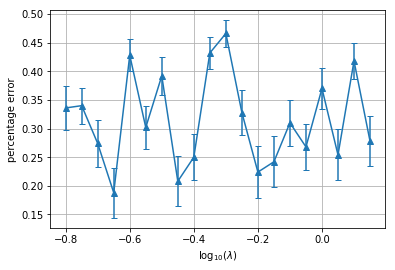

In [61]:
lambda_list3 = np.arange(-0.8, 0.2, 0.05, dtype=float)
err_list3 = []
std_list3 = []
for i in 10**lambda_list3:
    w_lamda = pegasos_sw(X_train, y_train, X_test, y_test,lamda = i,iteration = 400, threshold = 1e-10)
    err_list3.append(percent_err(X_test, y_test, w_lamda))
    std_list3.append(np.std(predict_all(X_test, w_lamda)))
    
plt.errorbar(lambda_list3, err_list3, std_list3/np.sqrt(500), marker='^', capsize=3)
plt.xlabel('$\log_{10}(\lambda)$')
plt.ylabel('percentage error')
plt.grid()
plt.show()

The best performed point is 10^-0.65

In [204]:
#7
#0.22
lamda_best = 10**-0.65
y_test_list = []
w_best = pegasos_sw(X_train, y_train, X_test, y_test,lamda = lamda_best,iteration = 400, threshold = 1e-10)
y_test_list = predict_all(X_test, w_best)

Total time: 0.03098583221435547
Loss is:  1.0


In [66]:
diff_idx = []
for idx in range(len(y_test)):
    if y_test[idx] != y_test_list[idx]:
        diff_idx.append(idx)

In [74]:
#pick two, (x_i)
#X_test[diff_idx[0]]
import operator
sorted(X_test[diff_idx[0]].items(), key=operator.itemgetter(1))

[('set', 1),
 ('great', 1),
 ('depression', 1),
 ('rival', 1),
 ('go', 1),
 ('illegal', 1),
 ('gambling', 1),
 ('take', 1),
 ('potential', 1),
 ('winners', 1),
 ('deliver', 1),
 ('them', 1),
 ('private', 1),
 ('locations', 1),
 ('drawings', 1),
 ('undisputed', 1),
 ('madame', 1),
 ('challenged', 1),
 ('schulz', 1),
 ('ruthless', 1),
 ('hoodlum', 1),
 ('turning', 1),
 ('against', 1),
 ('defies', 1),
 ('partner', 1),
 ('infamous', 1),
 ('wishes', 1),
 ('respect', 1),
 ('keep', 1),
 ('peace', 1),
 ("queens'", 1),
 ('strengthens', 1),
 ('acquaintance', 1),
 ('released', 1),
 ('prison', 1),
 ('becomes', 1),
 ('bodyguard', 1),
 ('proves', 1),
 ('worthy', 1),
 ('thwarts', 1),
 ('assassination', 1),
 ('attempt', 1),
 ('later', 1),
 ('takes', 1),
 ('she', 1),
 ('jailed', 1),
 ('tax', 1),
 ('evasion', 1),
 ("bumpy's", 1),
 ('restrained', 1),
 ('subdued', 1),
 ('declares', 1),
 ('out', 1),
 ('bloody', 1),
 ('warfare', 1),
 ('ensues', 1),
 ('faces', 1),
 ('obstacles', 1),
 ('methods', 1),
 ('disag

In [165]:
def times_dict(short, long):
    return_dic = {}
    for key, value in short.items():
        if key not in long.keys():
            return_dic[key] = 0
        else:
            return_dic[key] = long[key]*value
    return return_dic

In [166]:
wixi_0 = times_dict(X_test[diff_idx[0]], w_best)
sorted(wixi_0.items(), key =operator.itemgetter(1))

[('to', -0.7264093798780132),
 ('movie', -0.40573265727004665),
 ('an', -0.2947901337977678),
 ('all', -0.28263928598890004),
 ('this', -0.2704884381800307),
 ('on', -0.2683752472567495),
 ('only', -0.2630922699485455),
 ('a', -0.2282246197144007),
 ('there', -0.1204518826270449),
 ('have', -0.09984827112505044),
 ('if', -0.0972067824709485),
 ('are', -0.07924465962305603),
 ('so', -0.06550891862172613),
 ('here', -0.06445232316008542),
 ('at', -0.06339572769844494),
 ('wife', -0.06233913223680394),
 ('that', -0.06233913223680373),
 ('be', -0.058641048121061516),
 ('give', -0.05705615492860031),
 ('why', -0.054942964005318735),
 ('or', -0.054414666274498445),
 ('?', -0.0538863685436784),
 ('unfortunately', -0.04860339123547425),
 ('like', -0.047546795773833514),
 ('just', -0.04490530711973161),
 ('could', -0.043848711658090934),
 ('been', -0.04226381846562972),
 ('attempt', -0.04067892527316869),
 ('in', -0.03803743661906692),
 ('make', -0.036980841157426114),
 ('when', -0.036980841157

In [167]:
wixi_1 = times_dict(X_test[diff_idx[1]], w_best)
sorted(wixi_1.items(), key = operator.itemgetter(1))

[('to', -0.9905582452881998),
 ('this', -0.47335476681505373),
 ('just', -0.44905307119731613),
 ('that', -0.4363739256576261),
 ('a', -0.3993930845002012),
 ('on', -0.2683752472567495),
 ('film', -0.26626205633346745),
 ('are', -0.23773397886916808),
 ('be', -0.23456419248424606),
 ('or', -0.21765866509799378),
 ('movie', -0.20286632863502332),
 ('but', -0.1732816557090818),
 ('bad', -0.1553195328611894),
 ('like', -0.14264038732150053),
 ('only', -0.13154613497427275),
 ('there', -0.1204518826270449),
 ('all', -0.11305571439556002),
 ("doesn't", -0.10777273708735581),
 ('plot', -0.1014331643175116),
 ('have', -0.09984827112505044),
 ('if', -0.0972067824709485),
 ('any', -0.0876974233161819),
 ('played', -0.07765976643059475),
 ('make', -0.07396168231485223),
 ('get', -0.0729050868532114),
 ('characters', -0.06973530046828916),
 ("isn't", -0.0676221095450077),
 ('scenes', -0.0649806208909057),
 ('potential', -0.06445232316008545),
 ('enough', -0.06339572769844468),
 ('point', -0.06075

In [168]:
def times_dict_abs(short, long):
    return_dic = {}
    for key, value in short.items():
        if key not in long.keys():
            return_dic[key] = 0
        else:
            return_dic[key] = abs(long[key]*value)
    return return_dic

In [169]:
abs_wixi_0 = times_dict_abs(X_test[diff_idx[0]], w_best)
abs_wixi_1 = times_dict_abs(X_test[diff_idx[1]], w_best)

In [201]:
X_test_fill = X_test[diff_idx[0]].copy()
for key, value in w_best.items():
    if key not in X_test[diff_idx[0]].keys():
        X_test_fill[key] = 0

In [202]:
import pandas as pd
df_0 = pd.DataFrame([wixi_0, abs_wixi_0, X_test_fill, w_best], index=['wixi', '|wixi|', 'xi','wi']).T

In [203]:
df_0 = df_0.fillna(0)
df_0.sort_values(by='|wixi|', ascending=False)

,wixi,|wixi|,xi,wi
and,1.627157,1.627157,20.0,8.135785e-02
the,0.781352,0.781352,51.0,1.532063e-02
to,-0.726409,0.726409,11.0,-6.603722e-02
of,0.498713,0.498713,16.0,3.116957e-02
movie,-0.405733,0.405733,6.0,-6.762211e-02
is,0.348677,0.348677,10.0,3.486765e-02
an,-0.294790,0.294790,6.0,-4.913169e-02
all,-0.282639,0.282639,5.0,-5.652786e-02
this,-0.270488,0.270488,4.0,-6.762211e-02
on,-0.268375,0.268375,4.0,-6.709381e-02


In [198]:
X_test_fill_2 = X_test[diff_idx[1]].copy()
for key, value in w_best.items():
    if key not in X_test[diff_idx[1]].keys():
        X_test_fill_2[key] = 0
df_1 = pd.DataFrame([wixi_1, abs_wixi_1, X_test_fill_2, w_best], index=['wixi', '|wixi|', 'xi','wi']).T
df_1 = df_1.fillna(0)
df_1.sort_values(by='|wixi|', ascending=False)

,wixi,|wixi|,xi,wi
and,1.627157,1.627157,20.0,8.135785e-02
to,-0.990558,0.990558,15.0,-6.603722e-02
the,0.704749,0.704749,46.0,1.532063e-02
you,0.502939,0.502939,7.0,7.184849e-02
this,-0.473355,0.473355,7.0,-6.762211e-02
of,0.467543,0.467543,15.0,3.116957e-02
just,-0.449053,0.449053,10.0,-4.490531e-02
that,-0.436374,0.436374,14.0,-3.116957e-02
is,0.418412,0.418412,12.0,3.486765e-02
a,-0.399393,0.399393,14.0,-2.852808e-02
